# Level of Traffic Stress

based on https://github.com/mbonsma/LTS-OSM, inspired by https://muenchen.social/@scooooooott@urbanists.social/111745338643572229

This is in progress. Results are not accurate. https://peterfurth.sites.northeastern.edu/level-of-traffic-stress/

In [35]:
from pyrosm import OSM, get_data

region = "district-of-columbia"
fp = get_data(region)
osm = OSM(fp)
network = osm.get_network("all")

In [78]:
import numpy as np


def biking_permitted(row):
    if row["bicycle"] == "no":
        return False
    if row["access"] == "no":
        return False
    if row["highway"] == "motorway":
        return False
    if row["highway"] == "motorway_link":
        return False
    if row["highway"] == "proposed":
        return False
    if (
        (row["footway"] == "sidewalk")
        & ~(row["bicycle"] == "yes")
        & ((row["highway"] == "footway") | (row["highway"] == "path"))
    ):
        return False
    return True


def is_separated_path(row):
    if row["highway"] == "cycleway":
        return True
    if row["highway"] == "path":
        return True
    if (row["highway"] == "footway") & ~(row["footway"] == "crossing"):
        return True
    if row["cycleway"] == "track":
        return True
    if row["cycleway"] == "opposite_track":
        return True
    return False


def is_bike_lane(row):
    if row["cycleway"] in [
        "crossing",
        "lane",
        "left",
        "opposite",
        "opposite_lane",
        "right",
        "yes",
    ]:
        return True
    return False


def parking_present(
    row,
):  # Unfortunately, there is little parking data in OpenStreetMap. We will assume parking.
    return True


def get_max_speed(
    row,
    motorway=55.0,
    trunk=40.0,
    primary=30.0,
    secondary=30.0,
    tertiary=20.0,
    residential=20.0,
):
    if row["maxspeed"] == None:
        if row["highway"] in ["motorway", "motorway_link"]:
            return motorway
        if row["highway"] in ["trunk", "trunk_link"]:
            return trunk
        if row["highway"] in ["primary", "primary_link"]:
            return primary
        if row["highway"] in ["tertiary", "tertiary_link"]:
            return tertiary
        return residential
    if "mph" in row["maxspeed"]:
        return float(row["maxspeed"].split(" ")[0])
    return float(row["maxspeed"])


def get_lanes(row):
    if row["lanes"]:
        return int(row["lanes"])
    if row["oneway"]:
        if row["maxspeed"] == None:
            if row["highway"] in ["motorway", "motorway_link"]:
                return 3
            if row["highway"] in ["trunk", "trunk_link"]:
                return 2
            if row["highway"] in ["primary", "primary_link"]:
                return 2
            if row["highway"] in ["tertiary", "tertiary_link"]:
                return 1
            return 1
    if row["maxspeed"] == None:
        if row["highway"] in ["motorway", "motorway_link"]:
            return 6
        if row["highway"] in ["trunk", "trunk_link"]:
            return 4
        if row["highway"] in ["primary", "primary_link"]:
            return 4
        if row["highway"] in ["tertiary", "tertiary_link"]:
            return 1
        return 1

In [79]:
def level_of_traffic_stress_way_mixed_traffic(row):
    if row["oneway"] == "yes":
        if row["lanes_assumed"] >= 3:
            return 4
        if row["lanes_assumed"] >= 2:
            if row["maxspeed_assumed"] <= 25:
                return 3
            return 4
        if row["maxspeed_assumed"] >= 35:
            return 4
        if row["maxspeed_assumed"] >= 30:
            return 2
        return 1
    if row["lanes_assumed"] >= 6:
        return 4
    if row["lanes_assumed"] >= 4:
        if row["maxspeed_assumed"] <= 25:
            return 3
        return 4
    if row["maxspeed_assumed"] >= 35:
        return 4
    if row["maxspeed_assumed"] >= 30:
        return 2
    return 1


def level_of_traffic_stress_way_bike_lane_no_parking(row):
    if row["maxspeed_assumed"] >= 40:
        return 4
    if row["maxspeed_assumed"] >= 35:
        return 3
    if row["oneway"] == "yes":
        if row["lanes_assumed"] > 2:
            return 3
        if row["lanes_assumed"] == 2:
            return 2
    if row["lanes_assumed"] >= 4:
        return 3
    if row["maxspeed_assumed"] >= 30:
        return 2
    return 1


def level_of_traffic_stress_way_bike_lane_parking(row):
    if row["maxspeed_assumed"] >= 40:
        return 4
    if row["maxspeed_assumed"] >= 35:
        return 3
    if row["oneway"] == "yes":
        if row["lanes_assumed"] >= 2:
            return 3
    if row["lanes_assumed"] >= 4:
        return 3
    if row["maxspeed_assumed"] >= 30:
        return 2
    return 1


def level_of_traffic_stress_way(row):
    if not row["biking_permitted"]:
        return 0
    if row["is_separated_path"]:
        return 1
    if row["is_bike_lane"]:
        if row["parking_present"]:
            return level_of_traffic_stress_way_bike_lane_parking(row)
        return level_of_traffic_stress_way_bike_lane_no_parking(row)
    return level_of_traffic_stress_way_mixed_traffic(row)

In [80]:
network["is_separated_path"] = network.apply(is_separated_path, axis=1)
network["biking_permitted"] = network.apply(biking_permitted, axis=1)
network["is_bike_lane"] = network.apply(is_bike_lane, axis=1)
network["parking_present"] = network.apply(parking_present, axis=1)
network["lanes_assumed"] = network.apply(get_lanes, axis=1)
network["maxspeed_assumed"] = network.apply(get_max_speed, axis=1)
network["level_of_traffic_stress"] = network.apply(level_of_traffic_stress_way, axis=1)
print(network["level_of_traffic_stress"].value_counts())

level_of_traffic_stress
1    42856
0    12026
4     3169
3     1348
2      474
Name: count, dtype: int64


In [83]:
from lonboard import Map, PathLayer
from lonboard.colormap import apply_categorical_cmap

layer = PathLayer.from_geopandas(
    gdf=network[
        [
            "geometry",
            "level_of_traffic_stress",
            "name",
            "highway",
            "is_separated_path",
            "biking_permitted",
            "is_bike_lane",
            "parking_present",
            "oneway",
            "lanes",
            "lanes_assumed",
            "maxspeed",
            "maxspeed_assumed",
            "length",
        ]
    ],
    width_scale=10,
)
layer.get_color = apply_categorical_cmap(
    values=network["level_of_traffic_stress"],
    cmap={
        0: [0, 0, 0],  # black
        1: [0, 128, 0],  # green
        2: [255, 255, 0],  # yellow
        3: [255, 165, 0],  # orange
        4: [255, 0, 0],  # red
    },
)

Map(layers=[layer])

Map(layers=[PathLayer(get_color=<pyarrow.lib.FixedSizeListArray object at 0x12ee4c040>
[
  [
    0,
    128,
 …

<Axes: ylabel='level_of_traffic_stress'>

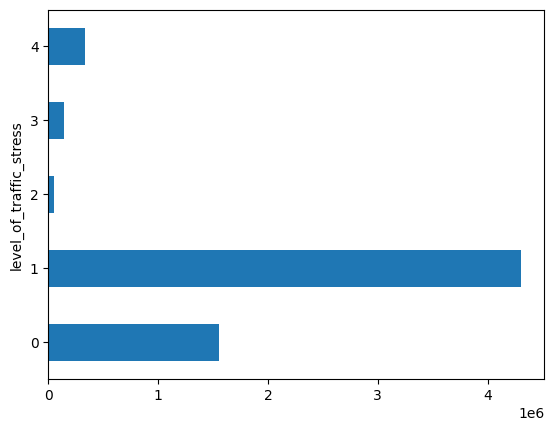

In [82]:
network["length"] = network.to_crs("EPSG:4087").length
network.groupby(["level_of_traffic_stress"])["length"].sum().plot(kind="barh")